In this notebook, I am going to work on converting my R script to Python. I was tasked with creating a 'social atlas' while competing my Geocomputation course at university, and chose to explore burglary crime across London. Here I will focus primarily on translating the R code to demonstrate the creation of maps and statistical tests in Python. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import pandas as pd
from pathlib import Path
import geopandas as gpd
import seaborn as sns
import esda
from libpysal import weights
# First, we import all dependencies.
# To highlight a few:
# geopandas is particularly useful for geographic data processing and storage,
# seaborn is necessary to perform the KDE analysis,
# esda and libpysal are used to perform spatial autocorrelations.

In [2]:
PATH = ('C:/Users/Callum/OneDrive/Geocomputation Project/')
burglary_point_loc = 'Data/Jan-19_burglary.csv'
# Long/Lat data for each individual burglary.

london_shapes_loc = 'Data/London_Ward_2018.shp'
# Shape file for London, with each different Ward outlined.

lsoa_shapes_loc = 'Data/LSOA_2011_London_gen_MHW.shp'
# Shape file for London, with each different LSOA area outlned.
# LSOAs are Lower Layer Super Output Areas, which are small geographical areas designed to
# include approximately 1,500 people per area, for a total of over 32,000 such areas in England.
# LSOAs are useful in geographical data analyses, and as such are used in some areas of this project.

lsoa_totals_loc = 'Data/Jan-19_lsoa_totals.csv'

In [3]:
lsoa_totals = pd.read_csv(f'{PATH}{lsoa_totals_loc}', encoding='utf8')
# Data for burglary totals in each LSOA, along with average house price in each LSOA.

lsoa_df = gpd.read_file(f'{PATH}{lsoa_shapes_loc}')
lsoa_df = lsoa_df.to_crs('epsg:4326')
lsoa_df = lsoa_df.join(lsoa_totals['Total Crime'])
lsoa_df = lsoa_df.join(lsoa_totals['House Price'])
# Creating a geopandas dataframe from the lsoa shapefile, and merging totals and burglary point data.
# Geometry data is projected to EPSG 4326.

In [4]:
burglary_data = pd.read_csv(f'{PATH}{burglary_point_loc}', encoding='utf8')
burglary_data.drop(columns=['Unnamed: 0', 'Unnamed: 1', 'Reported by', 'Falls within'], inplace=True)
burglary_points = gpd.GeoDataFrame(burglary_data, 
                geometry=gpd.points_from_xy(burglary_data.Longitude, 
                burglary_data.Latitude, crs='epsg:4326'))
burglary_points.head()

# Extract the Long/Lat of the burglary events from the dataframe above, and convert it into point data with GeoPandas.

,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,geometry
0,-0.074958,51.514151,On or near Aldgate High Street,E01000005,City of London 001E,Burglary,POINT (-0.07496 51.51415)
1,-0.084621,51.510200,On or near Botolph Lane,E01032739,City of London 001F,Burglary,POINT (-0.08462 51.51020)
2,-0.097645,51.515142,On or near St Martin'S Le Grand,E01032739,City of London 001F,Burglary,POINT (-0.09765 51.51514)
3,-0.079448,51.511554,On or near Fenchurch Place,E01032739,City of London 001F,Burglary,POINT (-0.07945 51.51155)
4,-0.080728,51.511611,On or near Supermarket,E01032739,City of London 001F,Burglary,POINT (-0.08073 51.51161)


[]

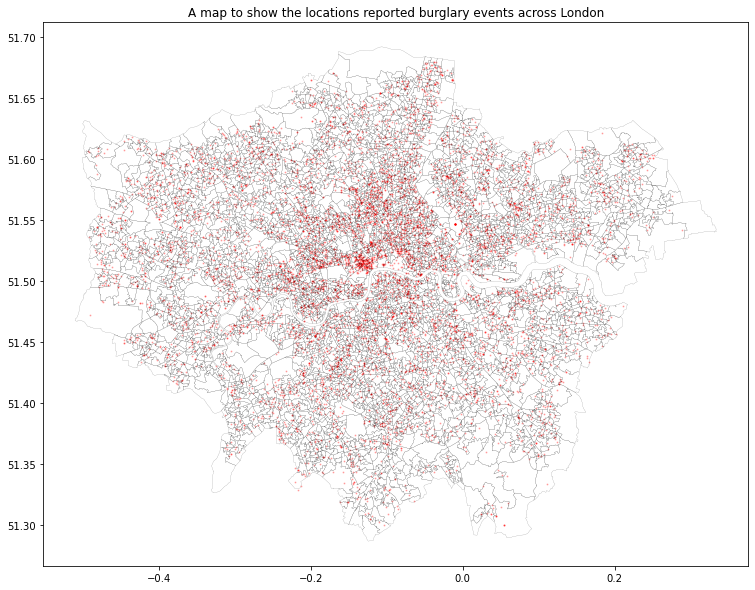

In [5]:
ax = lsoa_df.boundary.plot(edgecolor='black', figsize=(14,10), linewidth=0.1)
burglary_points.plot(ax=ax, color='r',
                    markersize=1, alpha=0.25)
ax.set_title('A map to show the locations reported burglary events across London')

ax.plot()
# Plot the burglary point data over a map of London.

[]

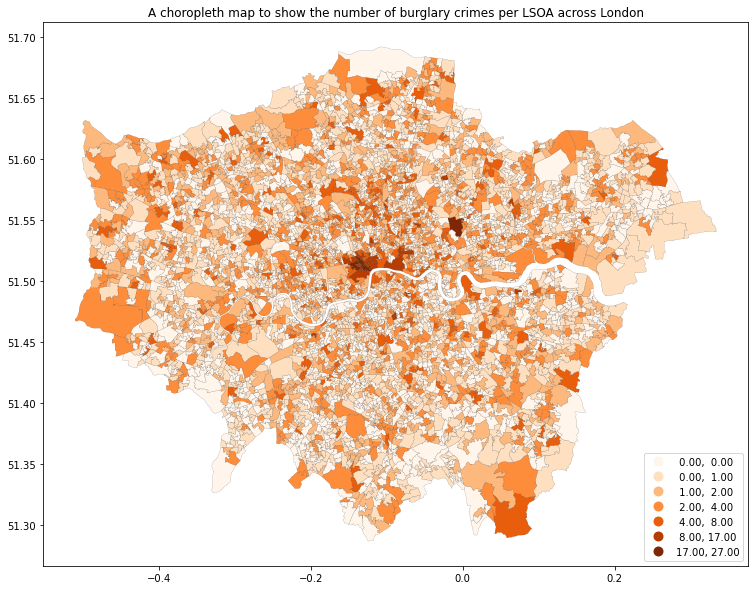

In [6]:
ax = lsoa_df.plot(edgecolor='black', figsize=(14,10), 
                 linewidth=0.10, 
                 column=lsoa_df['Total Crime'],
                legend=True, legend_kwds = {'loc' : 'lower right'},
                  cmap='Oranges', scheme='natural_breaks', k=7)

ax.set_title("A choropleth map to show the number of burglary crimes per LSOA across London")

ax.plot()
# This map shows the LSOAs with the higher number of crimes, essentially creating a heatmap.
# Natural breaks are used for the classification of LSOAs, although this could potentially be
# skewed by abnormally high values. In this instance, however, it created the most accessible map.
# We can begin to identify clusters of LSOAs that experience higher burglary rates here, and visually
# identify which LSOAs have the highest burglary rates.

[]

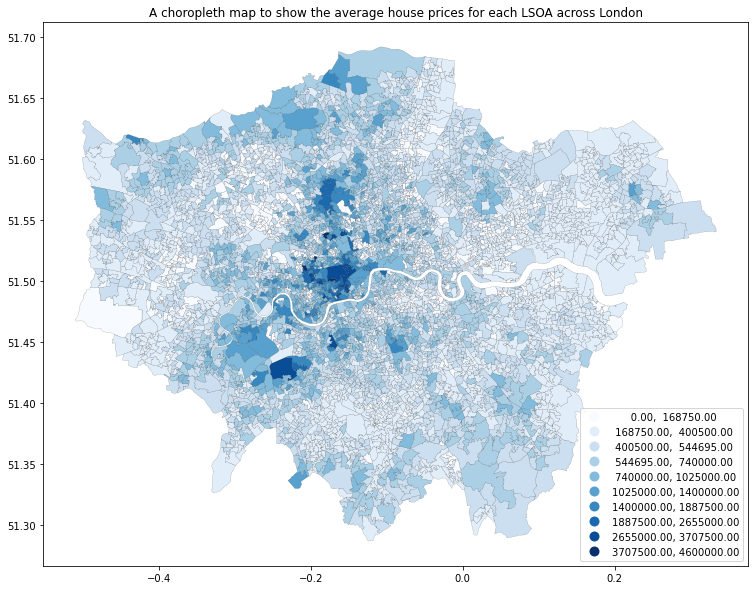

In [7]:
ax = lsoa_df.plot(edgecolor='black', figsize=(14,10), 
                 linewidth=0.10, 
                 column=lsoa_df['House Price'],
                legend=True, legend_kwds = {'loc' : 'lower right'},
                  cmap='Blues', scheme='natural_breaks', k=10)

ax.set_title("A choropleth map to show the average house prices for each LSOA across London")
ax.plot()
# This map shows house prices, in a process similar to the preceding map. Again, clusters
# are becoming much more evident here. 

[]

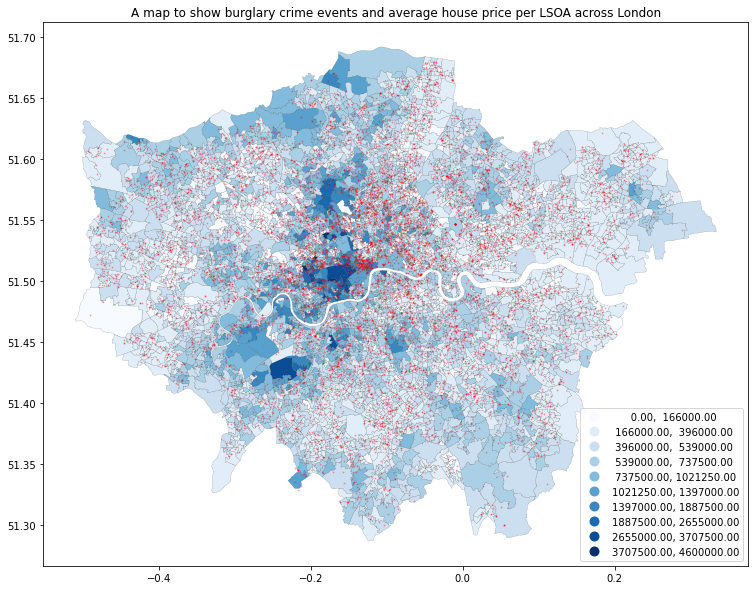

In [8]:
fig, ax = plt.subplots(figsize=(14, 10))
lsoa_df.plot(edgecolor='black', 
                 linewidth=0.10, ax=ax, 
                 column=lsoa_df['House Price'],
                 legend=True, legend_kwds = {'loc' : 'lower right'},
                 cmap='Blues', scheme='natural_breaks', k=10)

burglary_points.plot(ax=ax, color='r',
                    markersize=1, alpha=0.25)

ax.set_title('A map to show burglary crime events and average house price per LSOA across London')
ax.plot()
#To get a better feel of the data and how it relates, we can plot the 
# burglary point data over the choropleth map of average house prices.

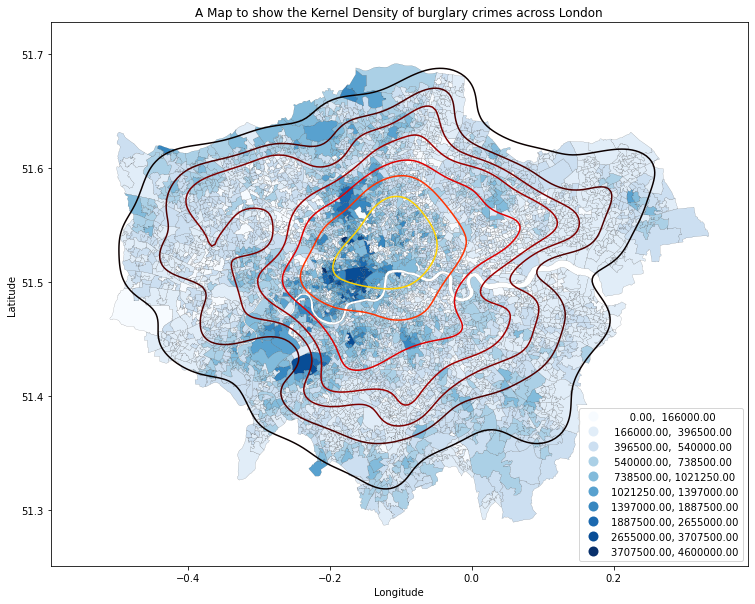

In [9]:
f, ax = plt.subplots(figsize = (14, 10))
ax.set_title("A Map to show the Kernel Density of burglary crimes across London")
lsoa_df.plot(edgecolor='black', 
                 linewidth=0.10, ax=ax, 
                 column=lsoa_df['House Price'],
                 legend=True, legend_kwds = {'loc' : 'lower right'},
                 cmap='Blues', scheme='natural_breaks', k=10)

sns.kdeplot(ax=ax, x=burglary_points.Longitude, y=burglary_points.Latitude, 
            shade=False, cmap='hot', levels=8)
plt.show()
# Creating a Kernel Density Estimate of burglary points across London, laid over LSOA average house prices.

In [10]:
lisa_weights = weights.distance.KNN.from_dataframe(lsoa_df, k=8)
lisa_weights.transform = 'R'


lisa_burglary = esda.moran.Moran_Local(lsoa_df['Total Crime'], lisa_weights)
lisa_houses = esda.moran.Moran_Local(lsoa_df['House Price'], lisa_weights)
# Calculating LISA values - Local Indicators of Spatial Autocorrelation, for burglary data per LSOA.
# This will be useful going forward, as we examine for clusters of autocorrelation in the data.

lsoa_df['lisa_burglary'] = lisa_burglary.Is
lsoa_df['lisa_houses'] = lisa_houses.Is
# Add these statistics to the Geodataframe.

c:\users\callum\appdata\local\programs\python\python38\lib\site-packages\libpysal\weights\util.py:1073: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = np.vstack([np.array(shape.centroid) for shape in first_choice])


In [11]:
sig_burglary = 1.0 * (lisa_burglary.p_sim < 0.05)
lsoa_df['sig_burglary'] = sig_burglary

sig_houses = 1.0 * (lisa_houses.p_sim < 0.05)
lsoa_df['sig_houses'] = sig_houses

# Determine which areas have statistically significant clustering, with p-values of < 0.05.

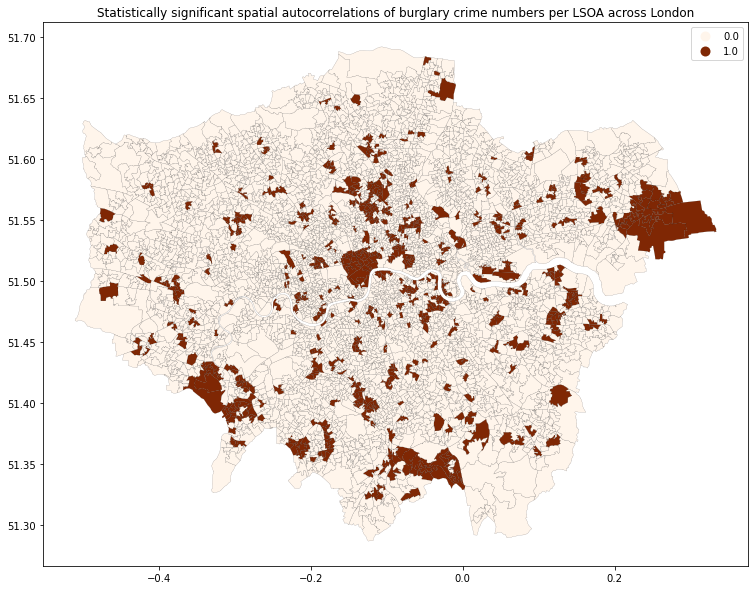

In [12]:
f, ax = plt.subplots(figsize=(14, 10))
lsoa_df.plot(ax=ax, edgecolor='black', linewidth=0.10,
             column=lsoa_df['sig_burglary'], 
             cmap='Oranges', categorical=True, 
             k=5, legend=True)
ax.set_title('Statistically significant spatial autocorrelations of burglary crime numbers per LSOA across London')
plt.show()

# Plt the statistically significant clustering of burglary crime numbers in each LSOA.
# When we compare this to our choropleth map of burglary crime, we can identify where there is significant 
# clusters of high crime. 

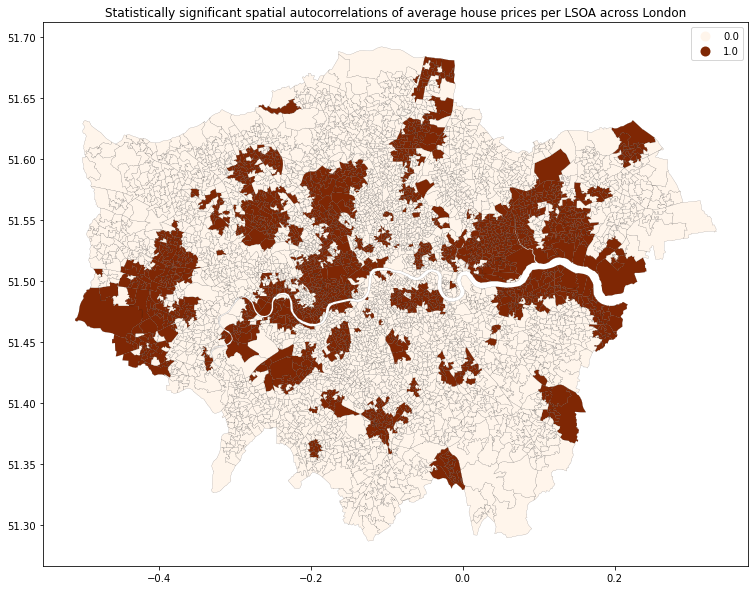

In [13]:
f, ax = plt.subplots(figsize=(14, 10))
lsoa_df.plot(ax=ax, edgecolor='black', linewidth=0.10,
             column=lsoa_df['sig_houses'], 
             cmap='Oranges', categorical=True, 
             k=5, legend=True)
ax.set_title('Statistically significant spatial autocorrelations of average house prices per LSOA across London')
plt.show()

# Much like the last plot, this map shows statistically significant clustering of house price averages 
# on a LSOA level. Comparing the two LISA significance maps with the two choropleth maps would provide
# us with a visual insight into how burglary crimes and house prices are spatially related.